In [1]:
import numpy as np
from scipy.optimize import minimize
from numpy import ceil, sqrt, tanh, tan, arctan, pi, sinh, cosh, sin, cos
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from shapely.geometry import LineString

#### Thermal calculation

In [2]:
def InterX(L1, L2=None):
    if L2 is None:
        L2 = L1
    x1, y1 = L1[0, :], L1[1, :]
    x2, y2 = L2[0, :], L2[1, :]
    P = np.empty((2, 0))
    for i in range(len(x1)-1):
        for j in range(len(x2)-1):
            dx1, dx2 = x1[i+1] - x1[i], x2[j+1] - x2[j]
            dy1, dy2 = y1[i+1] - y1[i], y2[j+1] - y2[j]
            det = dx1*dy2 - dy1*dx2
            if det == 0:
                continue  # Parallel lines
            dx, dy = x2[j] - x1[i], y2[j] - y1[i]
            u = (dx * dy2 - dy * dx2) / det
            v = (dx * dy1 - dy * dx1) / det
            if (0 <= u <= 1) and (0 <= v <= 1):
                Px = x1[i] + u*dx1
                Py = y1[i] + u*dy1
                P = np.hstack((P, [[Px], [Py]]))
    return P

In [5]:
def thermal_distribution_maxT_twosources(X, Data):
    
    # Unpack design variables
    Q_first, Q_second, d, b, L, c, L_duct, n, t, Xc_first, Yc_first, Xc_second, Yc_second = X

    # Unpack data
    Ti, c_source, d_source, c_module, d_module = Data

    # Define constants and calculate parameters
    lambda_air = 0.02551
    lambda_HS = 237
    visc_air_K = 156.2e-7
    visc_air = 184.9e-7
    density_air = 1.184
    density_Al = 2700
    c_air = 1007
    Pr = visc_air * c_air / lambda_air

    # Fan properties
    Fan_height = 40e-3
    Fan_weight = 50.8e-3
    Fan_power = 17.4
    Fan_A0 = 1081;
    Fan_A1 = -1.603e4;
    Fan_A2 = -2.797e6;
    Fan_A3 = 2.061e8;
    Fan_A4 = -5.034e9;
    Fan_A5 = 3.923e10;
    VF_max = 0.0466 / 3
    N_fan = ceil(b / Fan_height)
    
    width = b / n
    s = width - t

    # Pressure drop and thermal calculations
    V = np.arange(0.0005, VF_max * N_fan + 0.0005, 0.0005)
    dh = 2 * s * c / (s + c)
    Uhs = V / (n * s * c)
    EPS = s / c
    Kse = (1 - (1 - (n + 1) * t / b) ** 2) ** 2
    Ksc = 0.42 * (1 - (1 - (n + 1) * t / b) ** 2)
    fRe_fd = 12 / (np.sqrt(EPS) * (1 + EPS) * (1 - 192 * EPS * np.tanh(np.pi / 2 / EPS) / np.pi ** 5))
    fRe = np.sqrt(11.8336 * V / L / n / visc_air_K + fRe_fd ** 2)
    fapp = n * visc_air_K * np.sqrt(c * s) * fRe / V
    P_hs = (fapp * L / dh + Kse + Ksc) * density_air / 2 * Uhs ** 2
    
    dh_duct = 2 * b * (b + c) / (3 * b + c)
    K_venturi = 0.2
    U_duct = V / b / c
    EPS_duct = (b + c) / 2 / c
    fRe_fd_duct = 12 / (np.sqrt(EPS_duct) * (1 + EPS_duct) * (1 - 192 * EPS_duct * np.tanh(np.pi / 2 / EPS_duct) / np.pi ** 5))
    fapp_duct = visc_air_K * np.sqrt(b * (b + c)) / np.sqrt(2) / V * np.sqrt(11.8336 * V / L_duct / visc_air_K + fRe_fd_duct ** 2)
    P_duct = (fapp_duct * L_duct / dh_duct * 0.25 + K_venturi) * density_air / 2 * U_duct ** 2
    
    # Acceleration pressure drop
    P_acc = density_air / 2 * V ** 2 * (1 / (n * s * c) ** 2 - 1 / b ** 4)
    
    # Fan pressure curve
    P_fan = Fan_A0 + Fan_A1 * (V / N_fan * 3) + Fan_A2 * (V / N_fan * 3) ** 2 + Fan_A3 * (V / N_fan * 3) ** 3 + Fan_A4 * (V / N_fan * 3) ** 4 + Fan_A5 * (V / N_fan * 3) ** 5
    
    # Total pressure drop
    P_tot = P_hs + P_duct + P_acc
    V_cal = InterX(np.vstack((V, P_fan)), np.vstack((V, P_tot)))[0][0]


    # Fluid Dynamic Entry Length Calculation
    Lh_plus = 0.0822 * EPS * (1 + EPS) ** 2 * (1 - 192 * EPS * np.tanh(np.pi / 2 / EPS) / np.pi ** 5)
    Lh = Lh_plus * V_cal / n / visc_air_K
    
    # Thermal resistance
    Ahs = L * b
    Rth_d = d / lambda_HS / Ahs
    
    dh = 2 * s * c / (s + c)
    
    C1, C2, C3, C4 = 3.24, 1.5, 0.409, 2
    Cons = -0.3
    m = 2.27 + 1.65 * Pr ** 1.3
    z_star = L * n * visc_air_K / Pr / V_cal
    
    fRe_fd_th = 12 / (np.sqrt(EPS) * (1 + EPS) * (1 - 192 * EPS * np.tanh(np.pi / 2 / EPS) / np.pi ** 5))
    fRe_th = np.sqrt(11.8336 * V_cal / L / n / visc_air_K + fRe_fd_th ** 2)
    f_Pr = 0.564 / ((1 + (1.664 * Pr ** (1/6)) ** (9/2)) ** (2/9))
    Nu = ((C4 * f_Pr / np.sqrt(z_star)) ** m + ((C1 * fRe_th / 8 / np.sqrt(np.pi) / EPS ** Cons) ** 5 + (C2 * C3 * (fRe_th / z_star) ** (1/3)) ** 5) ** (m/5)) ** (1/m)
    
    h = Nu * lambda_air / dh
    
    eff_fin = np.tanh(np.sqrt(2 * h * (t + L) / lambda_HS / t / L) * c) / np.sqrt(2 * h * (t + L) / lambda_HS / t / L) / c
    Aeff = n * (2 * c * eff_fin + s) * L
    Rth_conv = 1 / (density_air * c_air * V_cal * (1 - np.exp(-h * Aeff / density_air / c_air / V_cal)))

    k = 237  # Thermal conductivity of heatsink (Aluminum)
    density_air = 1.184
    c_air = 1007

    ########################################

    Max_iter = 50
    
    # Create 2D grids for x and y
    x, y = np.meshgrid(np.arange(1e-3, b, 5e-3), np.arange(1e-3, L, 5e-3), indexing='ij')
    
    m_dot = density_air * V_cal  # Mass flow, assumed constant for this example
    A0 = (Q_first + Q_second) * (d / k / b / L + Rth_conv)
    
    # m1 series calculations
    m1_values = np.arange(1, Max_iter + 1)
    lamtha = m1_values * np.pi / b
    phi_m = (lamtha * np.sinh(lamtha * d) + h / k * np.cosh(lamtha * d)) / \
            (lamtha * np.cosh(lamtha * d) + h / k * np.sinh(lamtha * d))
    Am_1 = 2 * Q_first * (np.sin((2 * Xc_first + c_source) / 2 * lamtha) - \
             np.sin((2 * Xc_first - c_source) / 2 * lamtha)) / \
           (b * L * c_source * k * lamtha**2 * phi_m)
    Am_2 = 2 * Q_second * (np.sin((2 * Xc_second + c_source) / 2 * lamtha) - \
             np.sin((2 * Xc_second - c_source) / 2 * lamtha)) / \
           (b * L * c_source * k * lamtha**2 * phi_m)
    T_diff_m = np.sum(np.cos(lamtha[:, None, None] * x) * (Am_1 + Am_2)[:, None, None], axis=0)

    # n1 series calculations
    n1_values = np.arange(1, Max_iter + 1)
    thelta = n1_values * np.pi / L
    phi_n = (thelta * np.sinh(thelta * d) + h / k * np.cosh(thelta * d)) / \
            (thelta * np.cosh(thelta * d) + h / k * np.sinh(thelta * d))
    An_1 = 2 * Q_first * (np.sin((2 * Yc_first + d_source) / 2 * thelta) - \
             np.sin((2 * Yc_first - d_source) / 2 * thelta)) / \
           (b * L * d_source * k * thelta**2 * phi_n)
    An_2 = 2 * Q_second * (np.sin((2 * Yc_second + d_source) / 2 * thelta) - \
             np.sin((2 * Yc_second - d_source) / 2 * thelta)) / \
           (b * L * d_source * k * thelta**2 * phi_n)
    T_diff_n = np.sum(np.cos(thelta[:, None, None] * y) * (An_1 + An_2)[:, None, None], axis=0)


    # Double loop calculations for m and n series combined
    m_mn_values, n_mn_values = np.arange(1, 51), np.arange(1, 51)
    lamtha_mn, thelta_mn = np.meshgrid(m_mn_values * np.pi / b, n_mn_values * np.pi / L, indexing='ij')
    beta = np.sqrt(lamtha_mn**2 + thelta_mn**2)
    phi_mn = (beta * np.sinh(beta * d) + h / k * np.cosh(beta * d)) / \
             (beta * np.cosh(beta * d) + h / k * np.sinh(beta * d))
    Amn_1 = 16 * Q_first * np.cos(lamtha_mn * Xc_first) * np.sin(lamtha_mn * c_source / 2) * \
            np.cos(thelta_mn * Yc_first) * np.sin(thelta_mn * d_source / 2) / \
            (b * L * c_source * d_source * k * beta * lamtha_mn * thelta_mn * phi_mn)
    Amn_2 = 16 * Q_second * np.cos(lamtha_mn * Xc_second) * np.sin(lamtha_mn * c_source / 2) * \
            np.cos(thelta_mn * Yc_second) * np.sin(thelta_mn * d_source / 2) / \
            (b * L * c_source * d_source * k * beta * lamtha_mn * thelta_mn * phi_mn)
    T_diff_mn = np.sum(np.cos(lamtha_mn[:, :, None, None] * x) * np.cos(thelta_mn[:, :, None, None] * y) * 
                       (Amn_1[:, :, None, None] + Amn_2[:, :, None, None]), axis=(0, 1))

    Tf = Ti + (Q_first + Q_second) * y / m_dot / c_air / L
    
    # Final temperature difference calculation
    T_diff_total = A0 + T_diff_m + T_diff_n + T_diff_mn + Tf
    
    # Assuming Temperature_surface is meant to collect results
    Temperature_surface = np.stack((x.flatten(), y.flatten(), T_diff_total.flatten()), axis=-1)

    ########################################
    
    # Extract Tz (temperature values) and find maximum temperature
    Tz = Temperature_surface[:, 2]
    T_max = np.max(Tz)
    T_max += Q_first*0.117

    return T_max, Tz

In [7]:
%%time
Data = (25, 50e-3, 65e-3, 61.4e-3, 106e-3)
X = [397.980, 381.190, 0.021736, 0.20004, 0.32107, 0.015976, 0.045993, 45, 0.0011509, 0.062429, 0.120790, 0.128570, 0.059733]
Tmax, T = thermal_distribution_maxT_twosources(X, Data)
print(Tmax)

137.8190940731605
CPU times: total: 250 ms
Wall time: 265 ms


### Systematic comparison

In [8]:
import pandas as pd

df = pd.read_csv('./Dataset/TcTj_train.csv', header=None)
df.columns = ['Q1', 'Q2', 'd', 'b', 'L', 'c', 'L_duct', 'n', 't', 'xc1', 'yc1', 'xc2', 'yc2', 'Tc', 'Tj', 'w']
print(f"Pool: {df.shape[0]}")

# Remove outliers
df = df[df.Tj<250].reset_index(drop=True)
print(f"Filtered pol: {df.shape[0]}")

Pool: 9421
Filtered pol: 9386


In [16]:
# Extract X and y
X = df.iloc[:, :-3].to_numpy()
y = df.iloc[:, -2].to_numpy()
T_max_list = []

for i, input in enumerate(X[:1000]):
    if (i+1)%50 == 0:
        print(f"Processing {i+1} samples")
    Tmax, _ = thermal_distribution_maxT_twosources(input, Data)
    T_max_list.append(Tmax)

Processing 50 samples
Processing 100 samples
Processing 150 samples
Processing 200 samples
Processing 250 samples
Processing 300 samples
Processing 350 samples
Processing 400 samples
Processing 450 samples
Processing 500 samples
Processing 550 samples
Processing 600 samples
Processing 650 samples
Processing 700 samples
Processing 750 samples
Processing 800 samples
Processing 850 samples
Processing 900 samples
Processing 950 samples
Processing 1000 samples


Text(0, 0.5, 'Prediction')

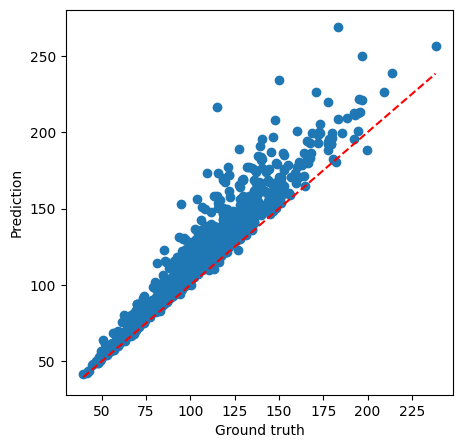

In [17]:
import matplotlib.pyplot as plt
y_reduced = y[:1000]

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(y_reduced, np.array(T_max_list), 'o')
ax.plot([y_reduced.min(), y_reduced.max()], [y_reduced.min(), y_reduced.max()], 'r--')
ax.set_xlabel('Ground truth')
ax.set_ylabel('Prediction')

In [ ]:
def create_samples(df, train_num):
   
    # Create dataset
    X = df.iloc[:, :-3].to_numpy()
    y = df.iloc[:, -2].to_numpy()
    
    # Train-test split
    if train_num < len(df):
        test_size = 1-train_num/len(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, _, y_train, _ = create_samples(df, 100)

#### Optimization routine

ChatGPT version

In [ ]:
def objective(x, *args):
    # Unpack fixed parameters
    Data = args[0]
    
    # Calculate weight
    weight_val = weight(*x[:7])  # Assuming the first 7 variables are d, b, L, c, n, t
    
    # Return the weight as the objective to minimize
    return weight_val

def constraint_maxT(x, *args):
    # Unpack fixed parameters
    Data, Tmax_threshold = args
    
    # Calculate Tmax
    Tmax = thermal_distribution_maxT_twosources(x, Data)
    
    # Constraint Tmax to be less than or equal to Tmax_threshold
    return Tmax_threshold - Tmax

def non_overlap_constraint(x, *args):
    # Unpack fixed parameters
    c_module, d_module = args
    
    # Calculate distances
    xc_dist = abs(x[-4] - x[-2])  # Assuming these are Xc_first and Xc_second
    yc_dist = abs(x[-3] - x[-1])  # Assuming these are Yc_first and Yc_second
    
    # Constraints for non-overlapping
    return min(xc_dist - c_module, yc_dist - d_module)

# Define bounds for each variable
bounds = [(d_min, d_max), (b_min, b_max), (L_min, L_max), (c_min, c_max), (L_duct_min, L_duct_max), (n_min, n_max),
          (1e-3, None),  # Placeholder for t, will need adjustment based on n and b
          (None, None), (None, None),  # Placeholder bounds for Xc_first, Yc_first
          (None, None), (None, None)]  # Placeholder bounds for Xc_second, Yc_second

# Additional arguments (fixed parameters)
Data = {...}  # Your data here
Tmax_threshold = ...  # Define your maximum allowed temperature

# Initial guess
x0 = [...]  # Initial guess for your design variables

# Optimization
result = minimize(objective, x0, args=(Data, Tmax_threshold), method='L-BFGS-B', bounds=bounds,
                  constraints=[{'type': 'ineq', 'fun': constraint_maxT, 'args': (Data, Tmax_threshold)},
                               {'type': 'ineq', 'fun': non_overlap_constraint, 'args': (Data['c_module'], Data['d_module'])}])

print(result)